<a href="https://colab.research.google.com/github/FFern97/Cats_and_Dogs_Classifier/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: _

In [16]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')



# Convertir a tf.data.Dataset y aplicar .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data_gen,
    output_signature=(tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
                      tf.TensorSpec(shape=(None,), dtype=tf.float32))
).repeat()


val_dataset = tf.data.Dataset.from_generator(
    lambda: val_data_gen,
    output_signature=(tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
                      tf.TensorSpec(shape=(None,), dtype=tf.float32))
).repeat()





test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=PATH,
                                                         shuffle=False,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         classes=['test'],
                                                         class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


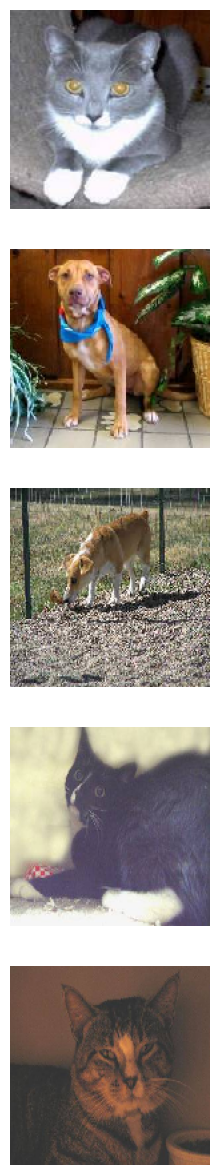

In [17]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Found 2000 images belonging to 2 classes.


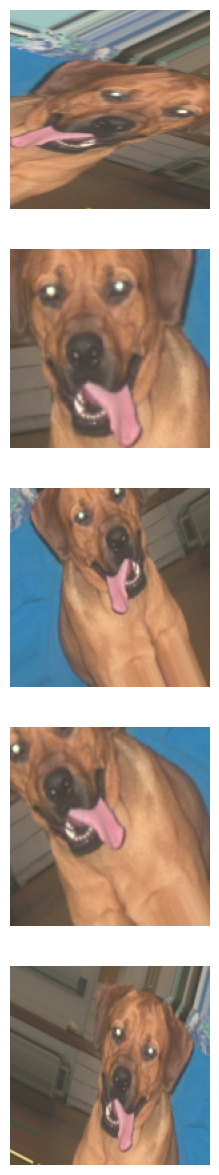

In [18]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)














Found 2000 images belonging to 2 classes.


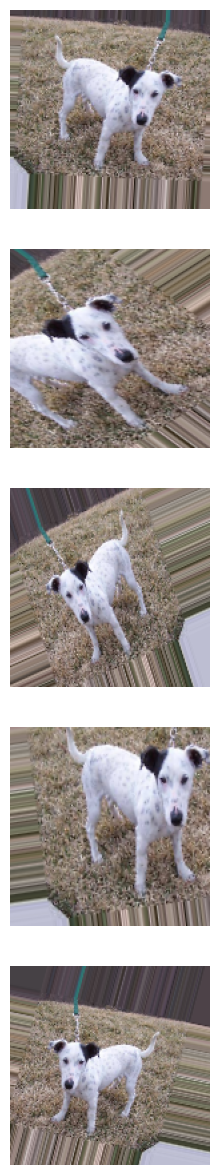

In [19]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [20]:
# 7
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3)),  # Usar Input para definir la forma de entrada
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Activación 'sigmoid' para obtener probabilidades
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,641,441 (40.59 MB)

 Trainable params: 10,641,441 (40.59 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# 8

steps_per_epoch = total_train // batch_size
validation_steps = total_val // batch_size


history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)




Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.6365 - loss: 0.6470 - val_accuracy: 0.6696 - val_loss: 0.6366
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6406 - loss: 0.6562 - val_accuracy: 0.5481 - val_loss: 0.6685
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.6599 - loss: 0.6264 - val_accuracy: 0.6440 - val_loss: 0.6316
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6172 - loss: 0.6701 - val_accuracy: 0.6442 - val_loss: 0.6189
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.6525 - loss: 0.6295 - val_accuracy: 0.5368 - val_loss: 0.6818
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5938 - loss: 0.6669 - val_accuracy: 0.6058 - val_loss: 0.6636
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.6000 - loss: 0.6658 - val_accuracy: 0.5681 - val_loss: 0.6595
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5156 - loss: 0.6968 - val_accuracy: 0.6058 - val_l

In [23]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


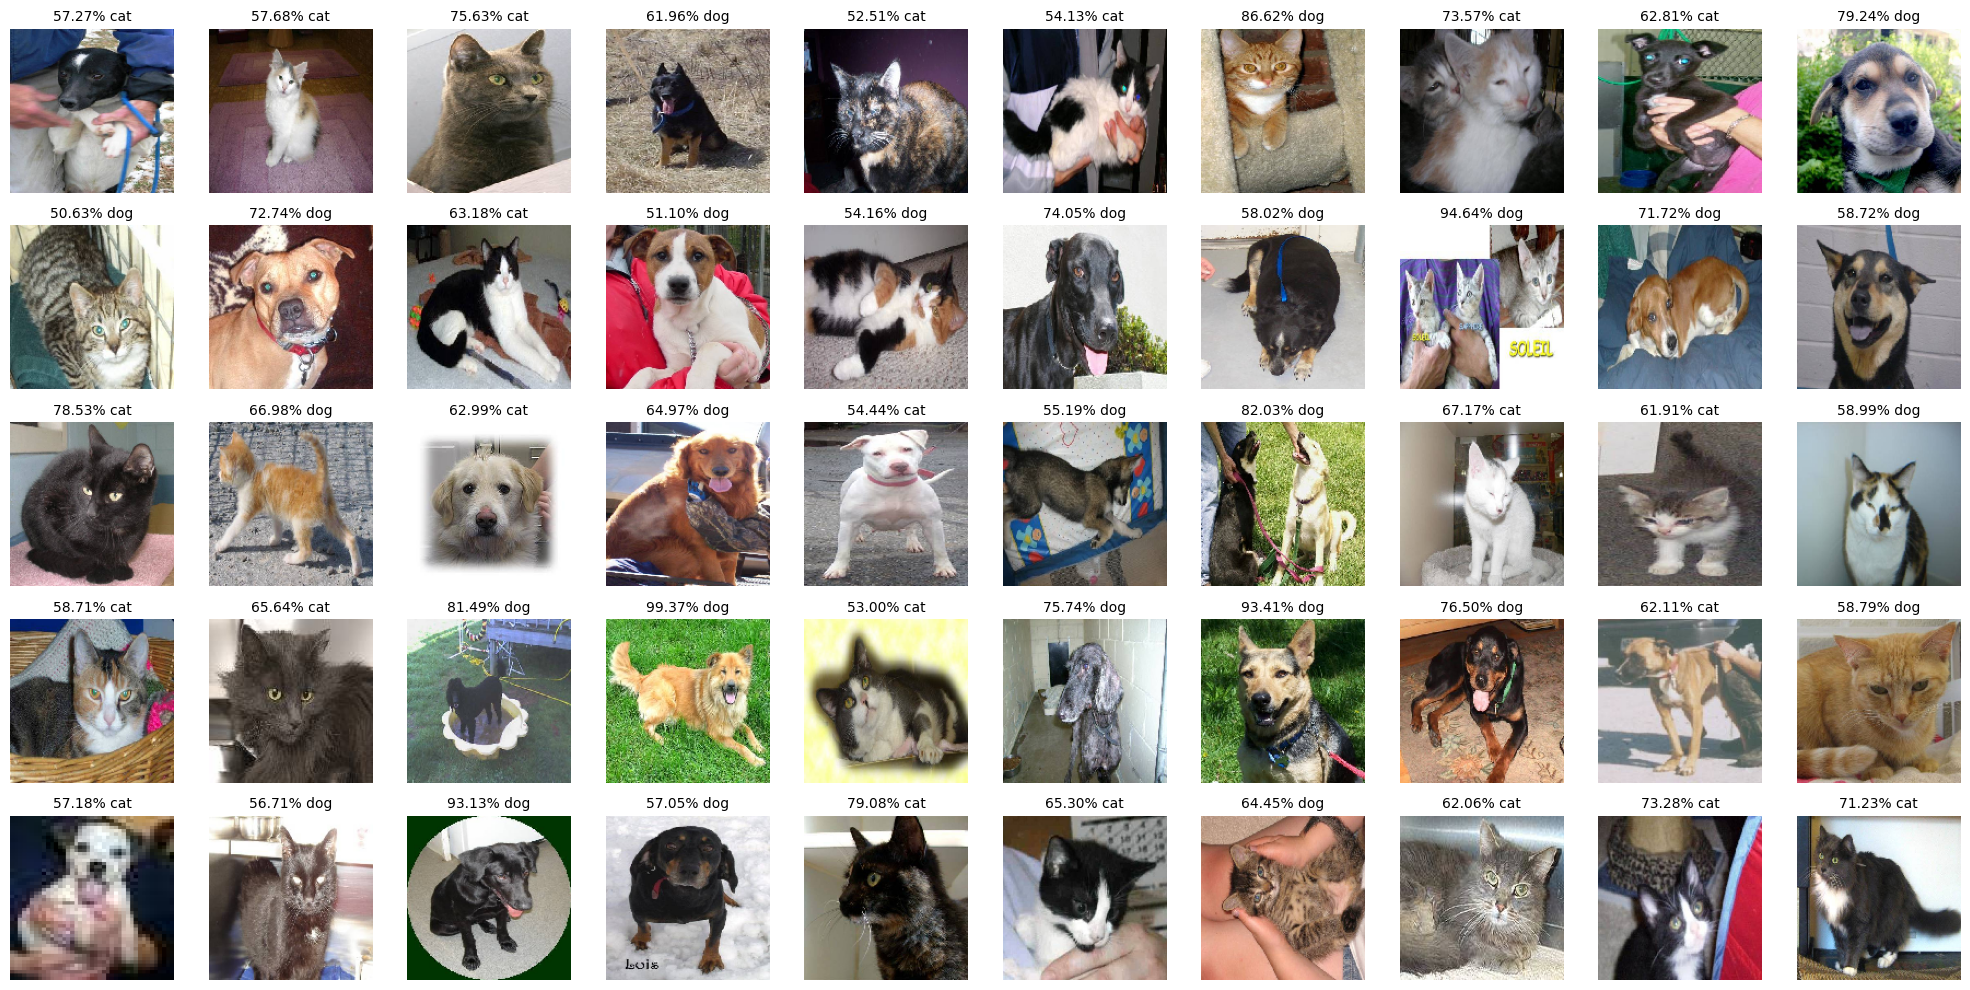

In [27]:
#10

test_images, test_labels = next(test_data_gen)

probabilities = model.predict(test_images)
probabilities_percentage = [int(prob[0] * 100) for prob in probabilities]

plotImages(test_images, probabilities)


def plotImages(images_arr, probabilities):
    fig, axes = plt.subplots(10, 5, figsize=(40, 20))
    axes = axes.flatten()
    for img, ax, prob in zip(images_arr, axes, probabilities):
        ax.imshow(img)
        probability = prob[0]
        label = f"{probability * 100:.2f}% dog" if probability >= 0.5 else f"{(1 - probability) * 100:.2f}% cat"
        ax.set_title(label, fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()







In [29]:
# 11
answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
           1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
           1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
           1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
           0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):

    if round(probability[0]) == answer:
        correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")


Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
